Equipe : 
- Abdessamed Seddiki
- Hind Ledra
- Inas Bouais
- Lydia Mouhoun
- Mohammed Arab
- Serine Gheddou
- Elamine Selmane

Groupe: SIQ2

Introduction:

 Ce Notebook comporte l'implémentation de 3 hyperheuristiques combiants plusieurs heuristiques dites de bas niveau pour résoudre le problème du Bin Packing (BPP), où l'objectif est de trouver la meilleure façon de répartir des objets de poids différents dans des conteneurs (bins) de même capacité afin de trouver le nombre de bins optimal à utiliser.

**PLAN**
1. Implémentation d'une hyperheuristique UCB
2. Implémentation d'une hyperheuristique avec la recherche Tabou (TS)
3. Implémentation d'une hyperheuristique avec AG

# **Implementation de l'hyperheuristique UCB**

# General imports and benchmarking

In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [ ]:
# Read input from the benchmark file
def read_input(file_path):
    with open(file_path, 'r') as file:
        num_objects = int(file.readline().strip())
        total_capacity = int(file.readline().strip())
        weights = [int(line.strip()) for line in file]

    return num_objects, total_capacity, weights

# Import the benchmark:
file_path = '../benchmarks/benchmark100.txt'
num_objects, total_capacity, weights = read_input(file_path)

# I. Une approche naive pour l'implémentation de l'UCB
### Inspirée du problème Multi-Armed Bandits
L'algorithme Upper Confidence Bound (UCB) est utilisé en apprentissage par renforcement (RL) pour équilibrer l'exploration et l'exploitation. La formule UCB est donnée par :

$$ \text{UCB}_i = \bar{X}_i + c \sqrt{\frac{\log n}{n_i}} $$
where:
- $\bar{X}_i$ est la valeur moyenne de la récompense de l'heuristique $i$,
- $c$ est une constante qui équilibre l'exploration et l'exploitation (souvent choisie comme $\sqrt{2}$)
- $n$ est le nombre total de sélections de toutes les actions jusqu'à présent,
- $n_i$ est le nombre de sélections de l'heuristique $i$ .

<br>

Dans le contexte de **l'apprentissage par renforcement (RL)**, l'algorithme Upper Confidence Bound (UCB) aide à sélectionner les actions qui maximisent les récompenses à long terme en considérant à la fois la valeur estimée de l'action et l'incertitude de cette estimation. Il assure que les actions avec un potentiel élevé sont suffisamment explorées tout en exploitant les actions qui sont connues pour bien performer :

* **Exploration:**  UCB encourage à essayer des heuristiques moins utilisées en attribuant un bonus d'exploration plus élevé appelé
$\Delta_i = \text{UCB}_i - \bar{X}_i $ . Cela aide à découvrir des stratégies de placement potentiellement meilleures et à échapper aux optima locaux.
* **Exploitation:** UCB favorise le choix des heuristiques très performantes basées sur le succès passé (mesuré par une fonction de récompense) $\bar{X}_i$

L'idée ici est de construire un ensemble de données de récompenses synthétiques pour chacune des heuristiques (Bandits) en fonction de leurs performances expérimentées sur de nombreuses instances. Cet ensemble de données de récompenses aiderait l'algorithme UCB à sélectionner l'heuristique la plus appropriée à utiliser tout en maintenant un compromis parfait entre exploitation et exploration.

In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random

### Testons le processus de sélection de l'UCB avec des récompenses aléatoires
Nous avons défini 4 heuristiques à sélectionner au cours de 1000 observations (objets). À chaque itération, le BinPacker calcule la valeur UCB pour chaque heuristique et sélectionne celle avec la valeur la plus élevée.


In [ ]:
# Define parameters
num_observations = 1000
num_heuristics = 4  # Adjust based on the number of bin packing algorithms you want to include

# Generate synthetic data
data = np.random.randint(0, 2, size=(num_observations, num_heuristics))  # Example: Random rewards between 0 and 100
#data = np.random.choice([-1, 0, 1], size=(num_observations, num_heuristics))  # Randomly select from -1, 0, 1

# Convert rewards list to a list of lists with each reward in a separate sublist
#rewards_2d = [[reward] for reward in rewards]

# Create DataFrame
df = pd.DataFrame(data , columns=[f"Heuristic_{i+1}" for i in range(num_heuristics)])
#df = pd.DataFrame(rewards_2d).T  # Transpose the rewards_2d list
#df.columns = [f"Heuristic_{i+1}" for i in range(num_heuristics)]


# Save data to CSV file
df.to_csv("bin_packing_rewards_random.csv", index=False)
df

,Heuristic_1,Heuristic_2,Heuristic_3,Heuristic_4
0,1,0,1,0
1,1,1,0,1
2,1,0,0,1
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
995,0,0,0,1
996,0,0,1,0
997,0,1,0,1
998,1,0,1,1


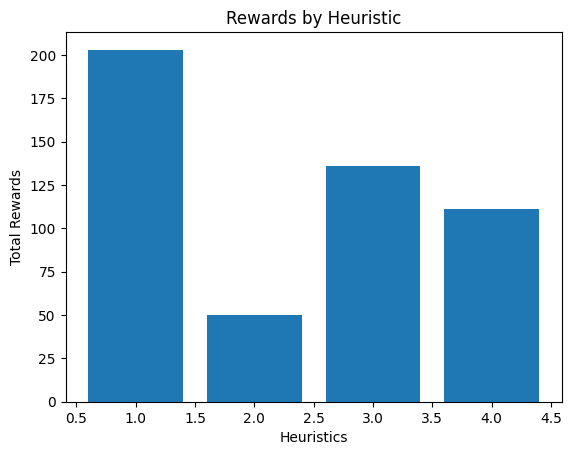

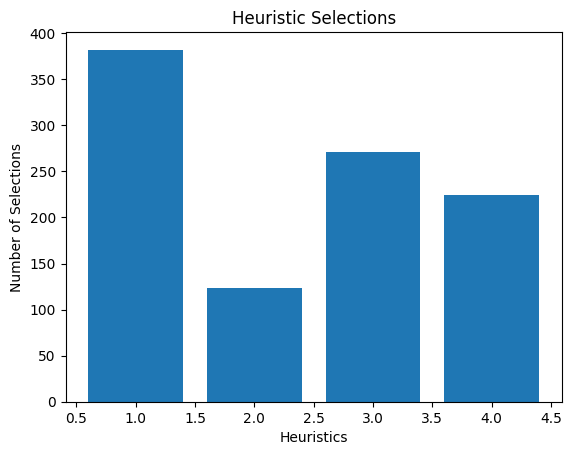

Total Rewards by UCB: 500
Heuristics Selected at Each Round by UCB: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 0, 1, 1, 0, 0, 2, 1, 1, 3, 3, 1, 0, 2, 2, 3, 3, 1, 0, 0, 2, 2, 2, 3, 3, 0, 0, 0, 0, 0, 1, 1, 2, 3, 0, 0, 1, 0, 0, 2, 2, 3, 3, 0, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 1, 2, 0, 2, 1, 3, 3, 0, 2, 2, 1, 3, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 1, 0, 2, 0, 0, 1, 1, 2, 2, 3, 3, 0, 1, 1, 1, 1, 2, 2, 3, 3, 0, 2, 2, 2, 2, 2, 3, 1, 2, 0, 0, 0, 0, 2, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 1, 1, 2, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 3, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 3, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2

In [ ]:
class BinPackerUCB:
    def __init__(self, data):
        self.data = data
        self.observations = len(data)
        self.num_heuristics = len(data.columns)
        self.num_selections = [0] * self.num_heuristics
        self.sum_rewards = [0] * self.num_heuristics
        self.heuristics_selected = []
        self.total_rewards = 0

    def ucb_select_heuristic(self, n):
        selected_heuristic = 0
        max_upper_bound = 0

        for i in range(self.num_heuristics):
            if self.num_selections[i] > 0:
                average_reward = self.sum_rewards[i] / self.num_selections[i]
                delta_i = math.sqrt(3/2 * math.log(n + 1) / self.num_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400

            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                selected_heuristic = i

        return selected_heuristic

    def run_ucb_algorithm(self):
        for n in range(self.observations):
            heuristic_index = self.ucb_select_heuristic(n)
            self.heuristics_selected.append(heuristic_index)
            self.num_selections[heuristic_index] += 1
            reward = self.data.values[n, heuristic_index]
            self.sum_rewards[heuristic_index] += reward
            self.total_rewards += reward

    def visualize_rewards(self):
        plt.bar(range(1, self.num_heuristics + 1), self.sum_rewards)
        plt.title('Rewards by Heuristic')
        plt.xlabel('Heuristics')
        plt.ylabel('Total Rewards')
        plt.show()

    def visualize_selections(self):
        plt.bar(range(1, self.num_heuristics + 1), self.num_selections)
        plt.title('Heuristic Selections')
        plt.xlabel('Heuristics')
        plt.ylabel('Number of Selections')
        plt.show()

# Load data (replace this with your dataset)
data = pd.read_csv("bin_packing_rewards_random.csv")

# Initialize and run UCB algorithm
ucb_bin_packer = BinPackerUCB(data)
ucb_bin_packer.run_ucb_algorithm()

# Visualize results
ucb_bin_packer.visualize_rewards()
ucb_bin_packer.visualize_selections()

print("Total Rewards by UCB:", ucb_bin_packer.total_rewards)
print("Heuristics Selected at Each Round by UCB:", ucb_bin_packer.heuristics_selected)


### Testons maintenant le processus de sélection de l'UCB avec des récompenses déterminées
Un ensemble de données de récompenses est construit en fonction des résultats de performance de chaque heuristique (temps d'exécution, nombre de conteneurs et qualité de la solution).

In [ ]:
def generate_random_dataset(num_instances):
    """
    Generate a random bin packing dataset with specified number of heuristic algorithms.

    Parameters:
        num_instances (int): Number of heuristic algorithms to generate.

    Returns:
        pd.DataFrame: DataFrame containing the random bin packing dataset.
    """
    # Generate random values for num_bins_used, execution_time, and solution_quality
    num_bins_used = np.random.randint(5, 20, size=num_instances)
    execution_time = np.random.uniform(0.1, 10.0, size=num_instances)
    solution_quality = np.random.randint(-5, 5, size=num_instances)  # Optimality difference

    # Create DataFrame
    df = pd.DataFrame({
        'num_bins_used': num_bins_used,
        'execution_time': execution_time,
        'solution_quality': solution_quality
    })

    return df

# Example usage
num_instances = 4  # Number of tested heuristics
dataset = generate_random_dataset(num_instances)

# Save dataset to CSV
dataset.to_csv("bin_packing_dataset.csv", index=False)
dataset

,num_bins_used,execution_time,solution_quality
0,19,1.200655,3
1,13,6.662887,-1
2,11,6.575638,-3
3,11,5.904734,1


In [ ]:
# Define rewards function
def calculate_reward(execution_time, num_bins_used, solution_quality):
    # Normalize metrics (e.g., between 0 and 1)
    #normalized_execution_time = (max_execution_time - execution_time) / max_execution_time
    #normalized_num_bins_used = (max_num_bins - num_bins_used) / max_num_bins
    #normalized_solution_quality = (max_solution_quality - solution_quality) / max_solution_quality

    # Assign rewards based on normalized metrics
    # Min execution_time and Min |solution_quality| => best reward
    #reward = alpha * normalized_execution_time + beta * normalized_num_bins_used + gamma * normalized_solution_quality
    #reward =  (alpha * normalized_execution_time + gamma * math.fabs(normalized_solution_quality))
    reward = 1 / (alpha * execution_time + gamma * math.fabs(solution_quality))
    return reward

# Define maximum values for normalization
max_execution_time = 10.0  # Adjust as per your dataset
max_num_bins = 20  # Adjust as per your dataset
max_solution_quality = 5  # Adjust as per your dataset

# Define weights for combining metrics
alpha = 0.5  # Weight for execution time
#beta = 0.3  # Weight for number of bins used
gamma = 0.5  # Weight for solution quality

# Generate random dataset
#num_instances = 1000  # Number of benchmark instances
#dataset = generate_random_dataset(num_instances)

# Calculate rewards for each benchmark instance
rewards = []
for index, row in dataset.iterrows():
    reward = calculate_reward(row['execution_time'], row['num_bins_used'], row['solution_quality'])
    rewards.append(reward)

# Add rewards to the dataset
dataset['reward'] = rewards

# Save the dataset with rewards to a CSV file
dataset.to_csv("bin_packing_rewards.csv", index=False)
dataset

,num_bins_used,execution_time,solution_quality,reward
0,19,1.200655,3,0.476116
1,13,6.662887,-1,0.260998
2,11,6.575638,-3,0.208863
3,11,5.904734,1,0.289656


In [ ]:
# Define parameters
num_observations = 1000
num_heuristics = len(rewards)  # Adjust based on the number of bin packing algorithms you want to include

# Generate synthetic data
#data = np.random.randint(0, 2, size=(num_observations, num_heuristics))  # Example: Random rewards between 0 and 100
#data = np.random.choice([-1, 0, 1], size=(num_observations, num_heuristics))  # Randomly select from -1, 0, 1

# Convert rewards list to a list of lists with each reward in a separate sublist
rewards_2d = [[reward] for reward in rewards]

# Create DataFrame
#df = pd.DataFrame(data , columns=[f"Heuristic_{i+1}" for i in range(num_heuristics)])
df = pd.DataFrame(rewards_2d).T  # Transpose the rewards_2d list
df.columns = [f"Heuristic_{i+1}" for i in range(num_heuristics)]


# Save data to CSV file
df.to_csv("bin_packing_rewards.csv", index=False)
df

,Heuristic_1,Heuristic_2,Heuristic_3,Heuristic_4
0,0.476116,0.260998,0.208863,0.289656


### UCB Appliqué à BPP-1D
Une fois les heuristiques de bin packing (first fit, best fit, next fit, worst fit) définies, les sélections et les récompenses sont initialisées à partir des données. À chaque itération, l'UCB de chaque heuristique est calculé, et celle avec la valeur UCB la plus élevée est sélectionnée et appliquée à l'objet actuel, mettant à jour les conteneurs. La récompense est ensuite calculée en fonction du nombre de conteneurs utilisés, et le nombre de sélections ainsi que les récompenses cumulatives pour l'heuristique sélectionnée sont mises à jour. Ces étapes sont répétées jusqu'à ce que tous les objets soient placés.

Enfin, la solution est analysée en termes du nombre total de conteneurs utilisés et des récompenses accumulées.

In [ ]:
# Définition des heuristiques de bin packing
def first_fit(bins, item, bin_capacity):
    for b in bins:
        if sum(b) + item <= bin_capacity:
            b.append(item)
            return bins
    bins.append([item])
    return bins

def best_fit(bins, item, bin_capacity):
    best_bin_index = None
    min_space_left = bin_capacity
    for i, b in enumerate(bins):
        space_left = bin_capacity - sum(b)
        if space_left >= item and space_left < min_space_left:
            best_bin_index = i
            min_space_left = space_left
    if best_bin_index is not None:
        bins[best_bin_index].append(item)
    else:
        bins.append([item])
    return bins

def next_fit(bins, item, bin_capacity):
    if len(bins) == 0 or sum(bins[-1]) + item > bin_capacity:
        bins.append([item])
    else:
        bins[-1].append(item)
    return bins

def worst_fit(bins, item, bin_capacity):
    worst_bin_index = None
    max_space_left = -1
    for i, b in enumerate(bins):
        space_left = bin_capacity - sum(b)
        if space_left >= item and space_left > max_space_left:
            worst_bin_index = i
            max_space_left = space_left
    if worst_bin_index is not None:
        bins[worst_bin_index].append(item)
    else:
        bins.append([item])
    return bins

class BinPackerUCB:
    def __init__(self, data, items, bin_capacity):
        self.data = data
        self.items = items
        self.bin_capacity = bin_capacity
        self.observations = len(items)
        self.num_heuristics = len(data.columns)
        self.num_selections = [0] * self.num_heuristics
        self.sum_rewards = [0] * self.num_heuristics
        self.heuristics_selected = []
        self.total_rewards = 0

    def ucb_select_heuristic(self, n):
        selected_heuristic = 0
        max_upper_bound = 0
        for i in range(self.num_heuristics):
            if self.num_selections[i] > 0:
                average_reward = self.sum_rewards[i] / self.num_selections[i]
                delta_i = math.sqrt(3/2 * math.log(n + 1) / self.num_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                selected_heuristic = i
        return selected_heuristic

    def apply_heuristic(self, heuristic_index, bins, item):
        if heuristic_index == 0:
            return first_fit(bins, item, self.bin_capacity)
        elif heuristic_index == 1:
            return best_fit(bins, item, self.bin_capacity)
        elif heuristic_index == 2:
            return next_fit(bins, item, self.bin_capacity)
        elif heuristic_index == 3:
            return worst_fit(bins, item, self.bin_capacity)
        else:
            raise ValueError("Heuristic index out of range")

    def run_ucb_algorithm(self):
        bins = []
        for n, item in enumerate(self.items):
            heuristic_index = self.ucb_select_heuristic(n)
            bins = self.apply_heuristic(heuristic_index, bins, item)
            print(f"Iteration {n+1}, Item {item}, Heuristic {heuristic_index + 1}, Bins: {bins}")

            # Simulate reward as inverse of the number of bins used (simplified reward function)
            reward = 1 / len(bins)

            self.heuristics_selected.append(heuristic_index)
            self.num_selections[heuristic_index] += 1
            self.sum_rewards[heuristic_index] += reward
            self.total_rewards += reward

        print(f"Final solution: {bins}")
        print(f"Total bins used: {len(bins)}")
        print(f"Total rewards: {self.total_rewards}")

# Exemple d'utilisation
if __name__ == "__main__":
    data = pd.read_csv("bin_packing_rewards.csv")
    items = [4, 8, 1, 4, 2, 1, 3, 8, 5, 7, 6, 4, 9, 3]  # Exemples d'items
    bin_capacity = 10

    bin_packer_ucb = BinPackerUCB(data, items, bin_capacity)
    bin_packer_ucb.run_ucb_algorithm()


Iteration 1, Item 4, Heuristic 1, Bins: [[4]]
Iteration 2, Item 8, Heuristic 2, Bins: [[4], [8]]
Iteration 3, Item 1, Heuristic 3, Bins: [[4], [8, 1]]
Iteration 4, Item 4, Heuristic 4, Bins: [[4, 4], [8, 1]]
Iteration 5, Item 2, Heuristic 1, Bins: [[4, 4, 2], [8, 1]]
Iteration 6, Item 1, Heuristic 2, Bins: [[4, 4, 2], [8, 1, 1]]
Iteration 7, Item 3, Heuristic 3, Bins: [[4, 4, 2], [8, 1, 1], [3]]
Iteration 8, Item 8, Heuristic 4, Bins: [[4, 4, 2], [8, 1, 1], [3], [8]]
Iteration 9, Item 5, Heuristic 1, Bins: [[4, 4, 2], [8, 1, 1], [3, 5], [8]]
Iteration 10, Item 7, Heuristic 2, Bins: [[4, 4, 2], [8, 1, 1], [3, 5], [8], [7]]
Iteration 11, Item 6, Heuristic 3, Bins: [[4, 4, 2], [8, 1, 1], [3, 5], [8], [7], [6]]
Iteration 12, Item 4, Heuristic 4, Bins: [[4, 4, 2], [8, 1, 1], [3, 5], [8], [7], [6, 4]]
Iteration 13, Item 9, Heuristic 1, Bins: [[4, 4, 2], [8, 1, 1], [3, 5], [8], [7], [6, 4], [9]]
Iteration 14, Item 3, Heuristic 2, Bins: [[4, 4, 2], [8, 1, 1], [3, 5], [8], [7, 3], [6, 4], [9]]


### Mise à jours des recompenses avec UCB et Epsilon-greedy:

L'exploration epsilon-greedy, lorsqu'elle est combinée avec UCB, vise à trouver un équilibre entre l'exploitation de l'heuristique actuellement la plus prometteuse (basée sur les calculs UCB) et l'exploration d'autres heuristiques potentiellement meilleures qui n'ont pas été utilisées aussi souvent, permettant ainsi d'échapper à un optimum local. Voici comment cela fonctionne :

- **Calcul de l'UCB** : L'algorithme calcule toujours la valeur UCB pour chaque heuristique, indiquant sa récompense estimée en fonction des performances passées.
- **Epsilon-greedy** : Avec une probabilité prédéfinie (epsilon), l'algorithme choisit une heuristique au hasard. C'est la phase d'exploration, où il s'aventure au-delà de l'option actuellement "meilleure" pour découvrir potentiellement des choix encore meilleurs.
Avec une probabilité de 1 - epsilon, l'algorithme sélectionne l'heuristique avec la plus haute valeur UCB. C'est la phase d'exploitation, où il tire parti des connaissances acquises à partir des sélections passées.








In [ ]:
# Définition des heuristiques de bin packing
def first_fit(bins, item, bin_capacity):
    for b in bins:
        if sum(b) + item <= bin_capacity:
            b.append(item)
            return bins
    bins.append([item])
    return bins

def best_fit(bins, item, bin_capacity):
    best_bin_index = None
    min_space_left = bin_capacity
    for i, b in enumerate(bins):
        space_left = bin_capacity - sum(b)
        if space_left >= item and space_left < min_space_left:
            best_bin_index = i
            min_space_left = space_left
    if best_bin_index is not None:
        bins[best_bin_index].append(item)
    else:
        bins.append([item])
    return bins

def next_fit(bins, item, bin_capacity):
    if len(bins) == 0 or sum(bins[-1]) + item > bin_capacity:
        bins.append([item])
    else:
        bins[-1].append(item)
    return bins

def worst_fit(bins, item, bin_capacity):
    worst_bin_index = None
    max_space_left = -1
    for i, b in enumerate(bins):
        space_left = bin_capacity - sum(b)
        if space_left >= item and space_left > max_space_left:
            worst_bin_index = i
            max_space_left = space_left
    if worst_bin_index is not None:
        bins[worst_bin_index].append(item)
    else:
        bins.append([item])
    return bins

class BinPackerUCB:
    def __init__(self, data, items, bin_capacity):
        self.data = data
        self.items = items
        self.bin_capacity = bin_capacity
        self.observations = len(items)
        self.num_heuristics = len(data.columns)
        self.num_selections = [0] * self.num_heuristics
        self.sum_rewards = [0] * self.num_heuristics
        self.heuristics_selected = []
        self.total_rewards = 0
        self.epsilon = 0.1

    def ucb_select_heuristic(self, n):
        selected_heuristic = 0
        max_upper_bound = 0
        for i in range(self.num_heuristics):
            self.sum_rewards[i] = 0  # Reset sum_rewards to 0 at each iteration

            if random.random() < self.epsilon:  # Epsilon-greedy exploration
              selected_heuristic = i
              break  # Exit the loop if exploration is chosen

            if self.num_selections[i] > 0:
                average_reward = self.sum_rewards[i] / self.num_selections[i]
                delta_i = math.sqrt(3/2 * math.log(n + 1) / self.num_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400
            #print(f"heuristic{i+1} with ucb= {upper_bound}")
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                selected_heuristic = i
        #print(f"selected= {selected_heuristic+1} with ucb= {max_upper_bound}")
        return selected_heuristic

    def apply_heuristic(self, heuristic_index, bins, item):
        if heuristic_index == 0:
            return first_fit(bins, item, self.bin_capacity)
        elif heuristic_index == 1:
            return best_fit(bins, item, self.bin_capacity)
        elif heuristic_index == 2:
            return next_fit(bins, item, self.bin_capacity)
        elif heuristic_index == 3:
            return worst_fit(bins, item, self.bin_capacity)
        else:
            raise ValueError("Heuristic index out of range")

    def run_ucb_algorithm(self):
        bins = []
        for n, item in enumerate(self.items):
            heuristic_index = self.ucb_select_heuristic(n)
            bins = self.apply_heuristic(heuristic_index, bins, item)
            print(f"\nIteration {n+1}, Item {item}, Heuristic {heuristic_index + 1}, Bins: {bins}")

            # Simulate reward as inverse of the number of bins used (simplified reward function)
            reward = 1 / len(bins)

            self.heuristics_selected.append(heuristic_index+1)
            self.num_selections[heuristic_index] += 1
            self.sum_rewards[heuristic_index] += reward
            self.total_rewards += reward

            # Update the rewards table
            self.update_rewards_table(heuristic_index, reward)

        print("\n___________________________")
        print(f"Selected heuristics: {self.heuristics_selected}")
        print(f"Final solution: {bins}")
        print(f"Total bins used: {len(bins)}")
        print(f"Total rewards: {self.total_rewards}")
        print(f"Rewards table track: \n{self.data}")

    def update_rewards_table(self, heuristic_index, reward):
        # Add the new reward to the data DataFrame
        new_rewards = self.data.iloc[-1].copy()  # Get the last row of rewards
        new_rewards[heuristic_index] += reward
        new_rewards_df = pd.DataFrame([new_rewards])
        print(f"new_rewards for heuristic {heuristic_index+1}: {reward}")
        self.data = pd.concat([self.data, new_rewards_df], ignore_index=True)  # Use concat instead of append

# Test Example
if __name__ == "__main__":
    data = pd.read_csv("bin_packing_rewards.csv")
    print("____ INIT ____\n",data)
    items = [4, 8, 1, 4, 2, 1, 3, 8, 5, 7, 6, 4, 9, 3]  # Exemples d'items
    bin_capacity = 10

    bin_packer_ucb = BinPackerUCB(data, items, bin_capacity)
    bin_packer_ucb.run_ucb_algorithm()

____ INIT ____
    Heuristic_1  Heuristic_2  Heuristic_3  Heuristic_4
0     0.476116     0.260998     0.208863     0.289656

Iteration 1, Item 4, Heuristic 1, Bins: [[4]]
new_rewards for heuristic 1: 1.0

Iteration 2, Item 8, Heuristic 2, Bins: [[4], [8]]
new_rewards for heuristic 2: 0.5

Iteration 3, Item 1, Heuristic 4, Bins: [[4, 1], [8]]
new_rewards for heuristic 4: 0.5

Iteration 4, Item 4, Heuristic 3, Bins: [[4, 1], [8], [4]]
new_rewards for heuristic 3: 0.3333333333333333

Iteration 5, Item 2, Heuristic 1, Bins: [[4, 1, 2], [8], [4]]
new_rewards for heuristic 1: 0.3333333333333333

Iteration 6, Item 1, Heuristic 2, Bins: [[4, 1, 2], [8, 1], [4]]
new_rewards for heuristic 2: 0.3333333333333333

Iteration 7, Item 3, Heuristic 3, Bins: [[4, 1, 2], [8, 1], [4, 3]]
new_rewards for heuristic 3: 0.3333333333333333

Iteration 8, Item 8, Heuristic 4, Bins: [[4, 1, 2], [8, 1], [4, 3], [8]]
new_rewards for heuristic 4: 0.25

Iteration 9, Item 5, Heuristic 1, Bins: [[4, 1, 2], [8, 1], [4, 

### Benchmark Testing:

In [ ]:
# Testing over 100 items

data = pd.read_csv("bin_packing_rewards.csv")
print("____ INIT ____\n",data)
items = weights  # Exemples d'items
bin_capacity = total_capacity

bin_packer_ucb = BinPackerUCB(data, items, bin_capacity)
bin_packer_ucb.run_ucb_algorithm()

____ INIT ____
    Heuristic_1  Heuristic_2  Heuristic_3  Heuristic_4
0     0.476116     0.260998     0.208863     0.289656

Iteration 1, Item 70, Heuristic 1, Bins: [[70]]
new_rewards for heuristic 1: 1.0

Iteration 2, Item 68, Heuristic 2, Bins: [[70], [68]]
new_rewards for heuristic 2: 0.5

Iteration 3, Item 68, Heuristic 2, Bins: [[70], [68], [68]]
new_rewards for heuristic 2: 0.3333333333333333

Iteration 4, Item 67, Heuristic 3, Bins: [[70], [68], [68], [67]]
new_rewards for heuristic 3: 0.25

Iteration 5, Item 67, Heuristic 4, Bins: [[70], [68], [68], [67], [67]]
new_rewards for heuristic 4: 0.2

Iteration 6, Item 65, Heuristic 1, Bins: [[70], [68], [68], [67], [67], [65]]
new_rewards for heuristic 1: 0.16666666666666666

Iteration 7, Item 65, Heuristic 3, Bins: [[70], [68], [68], [67], [67], [65], [65]]
new_rewards for heuristic 3: 0.14285714285714285

Iteration 8, Item 65, Heuristic 4, Bins: [[70], [68], [68], [67], [67], [65], [65], [65]]
new_rewards for heuristic 4: 0.125

I

# **Implémentation d'une hyperheuristique avec la Recherche Tabou**

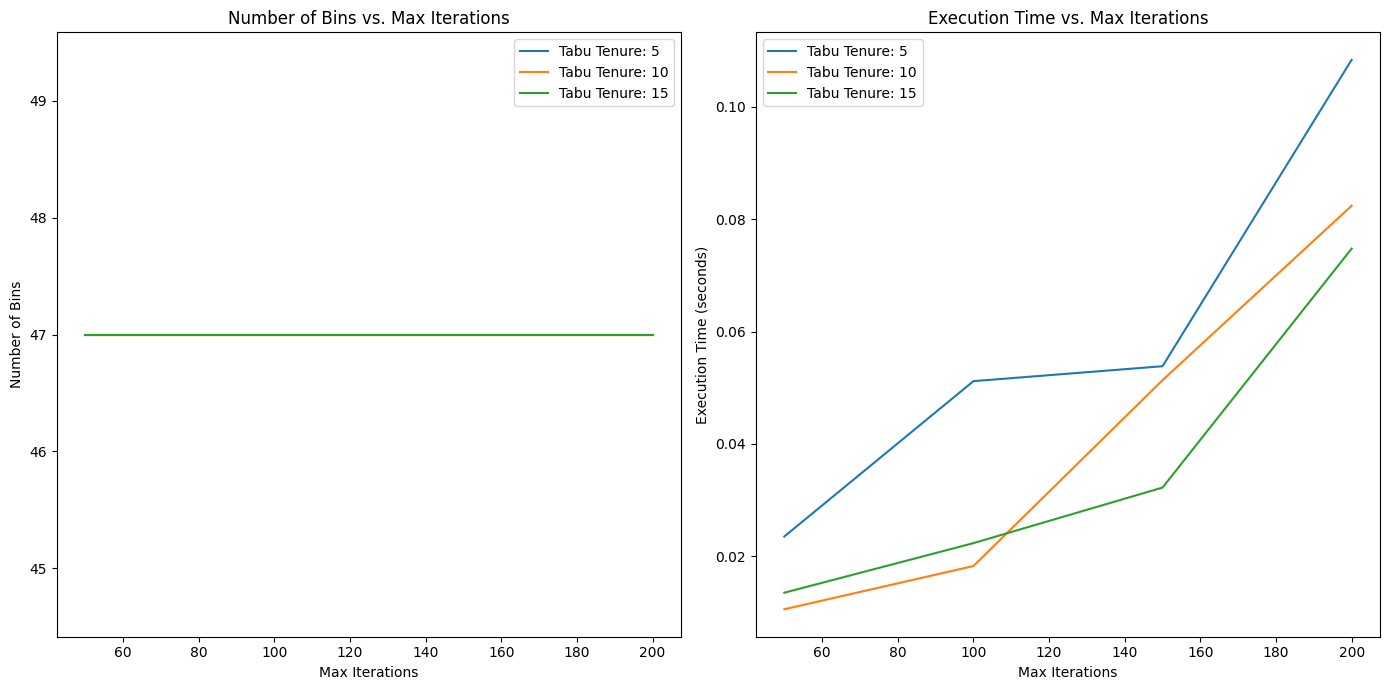

In [ ]:
import random
import time
import itertools
from collections import deque
import matplotlib.pyplot as plt


# Define the TabuSearchHyperheuristic class
class TabuSearchHyperheuristic:
    def __init__(self, tabu_tenure=5, max_iterations=100):
        self.tabu_tenure = tabu_tenure # Definir la longueur de la liste tabou
        self.max_iterations = max_iterations # Definir le nombre max des iterations
        self.tabu_list = deque(maxlen=tabu_tenure)

    def tabu_search(self, items, capacite_bin, low_level_heuristics):
        start_time = time.time()

        # Initial solution: a random permutation of heuristics
        current_solution = random.sample(low_level_heuristics, len(low_level_heuristics)) # générer un solution initiale aléatoire
        best_solution = current_solution
        best_bins = self.apply_heuristics(items, capacite_bin, best_solution) # appliquer les heuristiques dans l'odre pour résoudre le problème

        iteration = 0

        while iteration < self.max_iterations:
            neighbors = self.generate_neighbors(current_solution) # générer les voisins de la solution courante (i.e la liste des heuristiques)
            next_solution = None
            next_bins = None

            for neighbor in neighbors:
                if neighbor in self.tabu_list:
                    continue

                bins = self.apply_heuristics(items, capacite_bin, neighbor) # Appliquer dans le nouvel ordre les heuristiques
                if next_bins is None or len(bins) < len(next_bins):
                    next_solution = neighbor
                    next_bins = bins

            if next_bins and (len(next_bins) < len(best_bins)): # Si solution obtenue est meilleure alors changer la meilleure solution
                best_solution = next_solution
                best_bins = next_bins

            self.tabu_list.append(current_solution) # Ajouter la solution à la liste tabou
            current_solution = next_solution if next_solution else current_solution

            iteration += 1

        execution_time = time.time() - start_time
        return best_bins, execution_time

# Fonction générant les voisins en permutant les éléments d'une solution
    def generate_neighbors(self, solution):
        neighbors = []
        for i in range(len(solution)):
            for j in range(i + 1, len(solution)):
                neighbor = list(solution)
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbors.append(tuple(neighbor))
        return neighbors

#Fonction faisant appel aux heuristiques dans l'ordre
    def apply_heuristics(self, items, capacite_bin, heuristics):
        bins = [{'espace_libre': capacite_bin, 'items': []}]
        for item in items:
            placed = False
            for heuristic in heuristics:
                bins = heuristic(item, capacite_bin, bins)
                if self.is_valid_solution(bins, capacite_bin):
                    placed = True
                    break
            if not placed:
                bins.append({'espace_libre': capacite_bin - item, 'items': [item]})
        return bins

#Fonction verifiant que les solutions sont valides
    def is_valid_solution(self, bins, capacite_bin):
        for bin in bins:
            if bin['espace_libre'] < 0 or bin['espace_libre'] > capacite_bin:
                return False
        return True

# Definition des heuristiques de bas niveau
def next_fit(item, capacite_bin, bins):
    if not bins:
        bins.append({'espace_libre': capacite_bin, 'items': [item]})
        return bins

    for bin in bins:
        if item <= bin['espace_libre']:
            bin['items'].append(item)
            bin['espace_libre'] -= item
            return bins

    bins.append({'espace_libre': capacite_bin - item, 'items': [item]})
    return bins

def first_fit(item, capacite_bin, bins):
    if not bins:
        bins.append({'espace_libre': capacite_bin, 'items': [item]})
        return bins

    for bin in bins:
        if item <= bin['espace_libre']:
            bin['items'].append(item)
            bin['espace_libre'] -= item
            return bins

    bins.append({'espace_libre': capacite_bin - item, 'items': [item]})
    return bins

# Function to run experiments with different parameters and plot results
def run_experiments(weights, bin_capacity, low_level_heuristics, iterations_list, tenure_list):
    results = []

    for max_iterations in iterations_list:
        for tabu_tenure in tenure_list:
            tabu_search_hyper = TabuSearchHyperheuristic(tabu_tenure=tabu_tenure, max_iterations=max_iterations)
            best_solution, execution_time = tabu_search_hyper.tabu_search(weights, bin_capacity, low_level_heuristics)
            results.append((max_iterations, tabu_tenure, len(best_solution), execution_time))

    return results

def plot_results(results):
    iterations = sorted(set(result[0] for result in results))
    tenures = sorted(set(result[1] for result in results))

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    for tenure in tenures:
        bins = [result[2] for result in results if result[1] == tenure]
        times = [result[3] for result in results if result[1] == tenure]
        ax[0].plot(iterations, bins, label=f'Tabu Tenure: {tenure}')
        ax[1].plot(iterations, times, label=f'Tabu Tenure: {tenure}')

    ax[0].set_xlabel('Max Iterations')
    ax[0].set_ylabel('Number of Bins')
    ax[0].set_title('Number of Bins vs. Max Iterations')
    ax[0].legend()

    ax[1].set_xlabel('Max Iterations')
    ax[1].set_ylabel('Execution Time (seconds)')
    ax[1].set_title('Execution Time vs. Max Iterations')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Main function
if __name__ == "__main__":
    file_path = '../benchmarks/benchmark100.txt'
    num_objects, bin_capacity, weights = read_input(file_path)

    low_level_heuristics = [next_fit, first_fit]
    iterations_list = [50, 100, 150, 200]
    tenure_list = [5, 10, 15]

    results = run_experiments(weights, bin_capacity, low_level_heuristics, iterations_list, tenure_list)
    plot_results(results)


# ** Explication de la solution**



1.   **Stratégie de séléction:**
      La recherche tabou a été utilisé comme méthode de séléction des heuristiques de bas niveau. Une solution initiale est générée en utilisant une permutation aléatoire des heuristiques de bas niveau.L'algorithme explore les voisins de la solution actuelle en permutant les heuristiques et évalue leur qualité. La meilleure solution parmi les voisins est sélectionnée, à condition qu'elle ne soit pas dans la liste taboue.
2.   **Heuristique de bas niveau**

*   Next-Fit : Place l'objet courant dans le conteneur courant si possible ; sinon, ouvre un nouveau conteneur.
*   First-Fit : Tente de placer l'objet courant dans le premier conteneur qui a suffisamment d'espace ; sinon, ouvre un nouveau conteneur.

## **Conclusion**
Cette solution utilise une approche flexible et robuste pour résoudre le problème de bin-packing en combinant des heuristiques simples avec une métaheuristique avancée. Les expérimentations et la visualisation des résultats permettent une meilleure compréhension des performances de l'algorithme et aident à optimiser ses paramètres.

      

# **Implémentation d'une hyperheuristique avec AG**

Solution finale:  [[70, 30], [68, 31], [68, 30], [67, 33], [67, 30], [65, 35], [65, 34], [65, 29], [65, 29], [65, 28], [64, 36], [64, 36], [63, 37], [63, 37], [63, 36], [62, 38], [62, 38], [60, 40], [60, 36], [59, 41], [59, 41], [59, 28], [59, 27], [58, 26], [58, 26], [58, 26], [58, 26], [57, 43], [57, 43], [56, 44], [54, 46], [54, 46], [54, 44], [53, 47], [53, 47], [53, 47], [52, 48], [52, 47], [52, 43], [51, 49], [51, 49], [51, 25, 24], [51, 46], [41, 35, 23], [29, 25, 24, 22], [23, 23, 20, 20], [20, 20]]
Nombre de bins:  47
Temps d'exécution: 0.01290 secondes


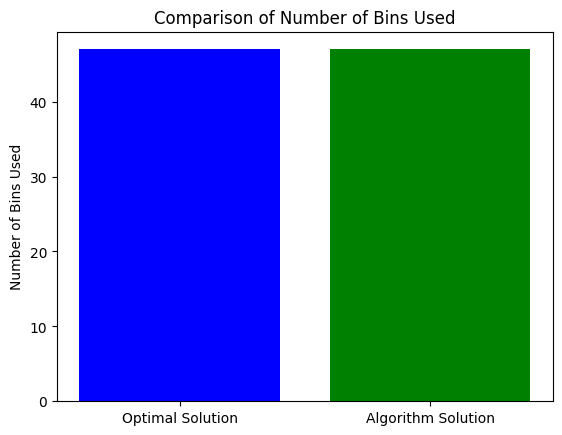

In [ ]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# Liste des heuristiques disponibles
heuristics = ['FF', 'NF', 'BF', 'WF']

def first_fit(bins, packet):
    for bin in bins:
        if sum(bin) + packet <= bin_capacity:  # Ajout de la vérification de la capacité
            bin.append(packet)
            return bins
    bins.append([packet])  # Créer un nouveau bac si aucun bac approprié n'est trouvé
    return bins

def next_fit(bins, packet):
    if bins and sum(bins[-1]) + packet <= bin_capacity:
        bins[-1].append(packet)
    else:
        bins.append([packet])  # Créer un nouveau bac si aucun bac approprié n'est trouvé
    return bins

def best_fit(bins, packet):
    best_bin_idx = -1
    min_remaining_space = float('inf')
    for idx, bin in enumerate(bins):
        remaining_space = bin_capacity - sum(bin)
        if remaining_space >= packet and remaining_space < min_remaining_space:
            best_bin_idx = idx
            min_remaining_space = remaining_space
    if best_bin_idx != -1:
        bins[best_bin_idx].append(packet)
    else:
        bins.append([packet])  # Créer un nouveau bac si aucun bac approprié n'est trouvé
    return bins

def worst_fit(bins, packet):
    worst_bin_idx = -1
    max_remaining_space = -1
    for idx, bin in enumerate(bins):
        remaining_space = bin_capacity - sum(bin)
        if remaining_space >= packet and remaining_space > max_remaining_space:
            worst_bin_idx = idx
            max_remaining_space = remaining_space
    if worst_bin_idx != -1:
        bins[worst_bin_idx].append(packet)
    else:
        bins.append([packet])  # Créer un nouveau bac si aucun bac approprié n'est trouvé
    return bins

# Fonction pour générer un chromosome aléatoire avec une longueur fixe
def generate_random_chromosome(chromosome_length):
    return ''.join(random.choices(heuristics, k=chromosome_length))

# Fonction pour générer la population initiale avec des chromosomes de même longueur
def generate_initial_population(population_size, chromosome_length):
    population = []
    for _ in range(population_size):
        chromosome = generate_random_chromosome(chromosome_length)
        population.append(chromosome)
    return population

# Sélection par tournoi
def tournament_selection(population, tournament_size):
    selected = []
    while len(selected) < tournament_size:
        contestants = random.sample(population, tournament_size)  # Sélectionner des individus aléatoires
        winner = min(contestants, key=fitness_function)           # Sélectionner le meilleur individu
        selected.append(winner)                                   # Ajouter le gagnant à la liste des sélectionnés
    return selected

# Croisement en deux points
def crossover(parent1, parent2):
    length = len(parent1)
    point1 = random.randint(1, length - 1)    # Premier point de croisement
    point2 = random.randint(point1, length - 1)    # Deuxième point de croisement
    child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]  # Croisement des parents
    child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]  # Croisement des parents
    return child1, child2

# Mutation
def mutation(child, mutation_rate=0.1):
    if random.random() < mutation_rate:
        index = random.randint(0, len(child) - 1)  # Choix aléatoire d'un indice de chromosome
        new_heuristic = random.choice(heuristics)  # Sélection aléatoire d'une nouvelle heuristique
        child = child[:index] + new_heuristic + child[index + 1:]  # Mutation
    return child



def fitness_function(chromosome, weight_optimality=1.0, weight_complexity=0.1):
    optimalities = {'N': 2, 'F': 1.7, 'B': 1.7, 'W': 1.9}
    complexities = {'N': 1, 'F': 2, 'B': 2, 'W': 2}  # O(n) = 1, O(n^2) = 2

    total_optimality = sum(optimalities.get(gene, 0) for gene in chromosome)
    total_complexity = sum(complexities.get(gene, 0) for gene in chromosome)

    fitness = (weight_optimality * total_optimality) + (weight_complexity * total_complexity)
    return fitness


# Trouver le meilleur chromosome dans une population
def best_chromosome(chromosomes):
    best_chromosome = None
    best_fitness = float('inf') # Initialiser à l'infini pour trouver la plus petite valeur
    for chromosome in chromosomes:
        fitness = fitness_function(chromosome)
        if fitness < best_fitness:
            best_fitness = fitness
            best_chromosome = chromosome
    return best_chromosome

def genetic_algorithm(population, population_size, max_iteration):
    for _ in range(max_iteration):
        parents = tournament_selection(population, tournament_size=2)
        childs = crossover(parents[0], parents[1])
        childs = [mutation(child) for child in childs]

        population.extend(childs)
        population = sorted(population, key=fitness_function)

        population = population[:population_size]

    return population

def hyper_heuristic_algorithm(population_size, initial_population, num_bins, items, max_iteration):
    solution = []
    current_population = initial_population
    current_items = items

    while current_items:
        selected_chromosome = best_chromosome(current_population)
        for gene in selected_chromosome:
            if current_items:  # Vérifiez si current_items n'est pas vide
                if gene == 'B':
                    solution = best_fit(solution, current_items[0])
                elif gene == 'F':
                    solution = first_fit(solution, current_items[0])
                elif gene == 'W':
                    solution = worst_fit(solution, current_items[0])
                elif gene == 'N':
                    solution = next_fit(solution, current_items[0])
                current_items.remove(current_items[0])
            else:
                break

        current_population = genetic_algorithm(current_population, population_size, max_iteration)

    return solution

# Lire les données à partir d'un fichier
def read_data_from_file(filename):
    with open(filename, 'r') as file:
        num_bins = int(file.readline().strip())                    # Nombre de bacs
        bin_capacity = int(file.readline().strip())                # Capacité des bacs
        items = []
        for line in file:
            items.extend(map(int, line.strip().split()))          # Ajouter les objets à la liste
        return num_bins, bin_capacity, items

def plot_solution(solution, optimal_solution):
    fig, ax = plt.subplots()
    bins_used = len(solution)
    ax.bar(["Optimal Solution", "Algorithm Solution"], [optimal_solution, bins_used], color=['blue', 'green'])
    ax.set_ylabel('Number of Bins Used')
    ax.set_title('Comparison of Number of Bins Used')
    plt.show()

if __name__ == "__main__":

    filename = "../benchmarks/benchmark100.txt"  # Nom du fichier d'entrée
    num_bins, bin_capacity, items = read_data_from_file(filename)  # Lire les données à partir du fichier


    population_size = 10
    chromosome_length = 5  # Longueur fixe de chaque chromosome
    max_iteration = 20
    initial_population = generate_initial_population(population_size, chromosome_length)

    start_time = time.time()

    solution = hyper_heuristic_algorithm(population_size, initial_population, num_bins, items, max_iteration)

    end_time = time.time()
    execution_time = end_time - start_time


    print("Solution finale: ", solution)
    print("Nombre de bins: ",len(solution))
    print("Temps d'exécution: {:.5f} secondes".format(execution_time))

    plot_solution(solution, optimal_solution=47)



La solution proposée utilise un algorithme d'hyper-heuristique combiné à un algorithme génétique pour résoudre un problème d'allocation de bacs. L'algorithme commence par générer une population initiale de solutions représentées par des chromosomes composés d'une séquence d'heuristiques. Ensuite, il applique une stratégie d'hyper-heuristique pour sélectionner les heuristiques à utiliser pour allouer les objets aux bacs. L'algorithme évalue chaque solution en tenant compte à la fois de l'efficacité de l'allocation et de la complexité de l'algorithme utilisé. Les solutions sont améliorées itérativement à l'aide d'un algorithme génétique, qui comprend des opérateurs de sélection, de croisement et de mutation. Le processus se répète jusqu'à ce qu'une solution satisfaisante soit trouvée ou jusqu'à ce qu'un nombre maximum d'itérations soit atteint. Enfin, la solution optimale est affichée graphiquement pour une comparaison avec la solution trouvée. Ce processus permet de trouver une allocation efficace des objets aux bacs tout en optimisant l'utilisation des ressources disponibles.

Quelques paramètres:
- nombre d'itérations de l'AG
- la taille du chromosome
- la taille de la population initiale
- l'optimalité de chaque heuristique et la complexité (faire un compromis entre l'optimalité et le temps d'exécution)